In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import DenseNet201
%matplotlib inline

# to ignore displaying warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync) 

REPLICAS:  1


In [4]:
imagePatches = glob('IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1251_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1301_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1351_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1501_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1551_class0.png


In [5]:
class0_no = [] # 0 = no cancer
class1_cancer = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0_no.append(filename)
    else:
        class1_cancer.append(filename)

In [6]:
print(len(class1_cancer))
print(len(class0_no))

78785
198737


In [7]:
import cv2
test = cv2.imread('IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_COLOR)
test.shape

(50, 50, 3)

In [8]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays
class0_no_array = get_image_arrays(class0_no, 0)
class1_cancer_array = get_image_arrays(class1_cancer, 1)

In [9]:
combined_data = np.concatenate((class0_no_array, class1_cancer_array))
random.seed(42)
random.shuffle(combined_data)

In [10]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(194265, 50, 50, 3) (83257, 50, 50, 3) (194265, 2) (83257, 2)


In [12]:
base_model = tf.keras.applications.DenseNet201(input_shape=(50,50,3),include_top=False,weights="imagenet")

In [14]:
# Building Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D,RepeatVector

# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.4))

model.add(Flatten())
model.add(RepeatVector(2))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

In [15]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 dropout (Dropout)           (None, 1, 1, 1920)        0         
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 repeat_vector (RepeatVecto  (None, 2, 1920)           0         
 r)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 2)                 7682      
                                                        

In [16]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [17]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [18]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.75, min_lr = 1e-10)

mcp = ModelCheckpoint('DenseNet201_model.h5')

es = EarlyStopping(verbose=1, patience=5)

In [19]:
model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=METRICS)

In [20]:
DenseNet201_history=model.fit(X_train, 
                              y_train,
                              validation_data=(X_test, y_test),
                              verbose = 1, 
                              epochs = 10,
                              callbacks=[lrd,mcp,es])

Epoch 1/10
6071/6071 [==============================] - 13217s 2s/step - loss: 0.1500 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9816 - f1_score: 0.9540 - val_loss: 2.4624 - val_accuracy: 0.9544 - val_precision: 0.9544 - val_recall: 0.9544 - val_auc: 0.9564 - val_f1_score: 0.9544 - lr: 0.0010
Epoch 2/10
6071/6071 [==============================] - 11772s 2s/step - loss: 0.1422 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9834 - f1_score: 0.9547 - val_loss: 2.2533 - val_accuracy: 0.9558 - val_precision: 0.9558 - val_recall: 0.9558 - val_auc: 0.9819 - val_f1_score: 0.9558 - lr: 0.0010
Epoch 3/10
6071/6071 [==============================] - 11642s 2s/step - loss: 0.1393 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9838 - f1_score: 0.9554 - val_loss: 0.1579 - val_accuracy: 0.9562 - val_precision: 0.9562 - val_recall: 0.9562 - val_auc: 0.9886 - val_f1_score: 0.9562 - lr: 0.0010
Epoch 4/10
6071/6071 [==============================

In [21]:
evaluation_results = model.evaluate(X_test, y_test)

accuracy = evaluation_results[1]
precision = evaluation_results[2]
recall = evaluation_results[3]
f1_score = evaluation_results[4]

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score", f1_score)

2602/2602 [==============================] - 1030s 395ms/step - loss: 1.1029 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9850 - f1_score: 0.9487
Accuracy: 0.9486649632453918
Precision: 0.9486649632453918
Recall: 0.9486649632453918
F1 score 0.9850243330001831


In [22]:
print(DenseNet201_history.history['loss']) 
print(DenseNet201_history.history['accuracy']) 
print(DenseNet201_history.history['val_loss'])  
print(DenseNet201_history.history['val_accuracy'])  


[0.1499558836221695, 0.14216826856136322, 0.1393032819032669, 0.130502387881279, 0.125429168343544, 0.12534064054489136, 0.16660551726818085, 0.1417161375284195, 0.12462487816810608, 0.12348739802837372]
[0.9539700746536255, 0.9546753168106079, 0.9553651213645935, 0.956214427947998, 0.9581242203712463, 0.9589375257492065, 0.9556173086166382, 0.9555967450141907, 0.9578925967216492, 0.9586440920829773]
[2.4623613357543945, 2.2532522678375244, 0.1578899472951889, 0.12064224481582642, 0.11704381555318832, 0.13720184564590454, 1.561657428741455, 2.6679608821868896, 0.23667892813682556, 1.1028538942337036]
[0.9544422626495361, 0.9557634592056274, 0.9562078714370728, 0.9590064287185669, 0.9573969841003418, 0.9549707770347595, 0.9554752111434937, 0.9567243456840515, 0.9584059119224548, 0.9486649632453918]


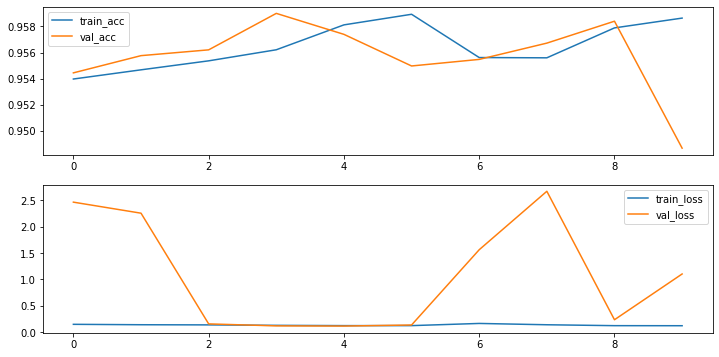

In [31]:
#plot the accuracy graph
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(DenseNet201_history.history['accuracy'], label="train_acc")
plt.plot(DenseNet201_history.history['val_accuracy'], label = "val_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(DenseNet201_history.history['loss'], label = "train_loss")
plt.plot(DenseNet201_history.history['val_loss'], label = "val_loss")
plt.legend()

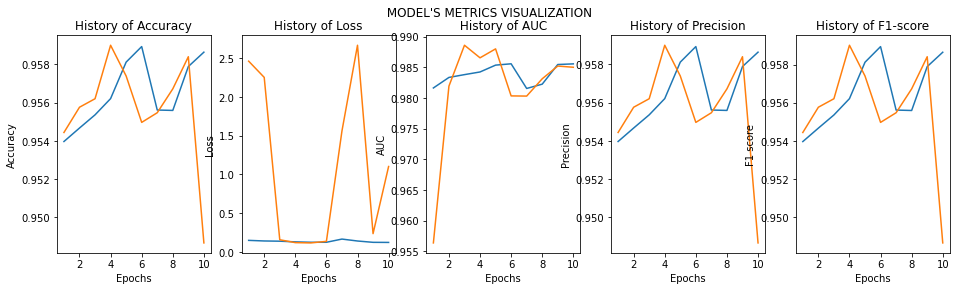

In [29]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (16,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    #ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    #ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title(' History of AUC ')
    ax3.set_xlabel(' Epochs ')
    ax3.set_ylabel('AUC')
    #ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    #ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    #ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(DenseNet201_history.history['accuracy'],DenseNet201_history.history['val_accuracy'],
               DenseNet201_history.history['loss'],DenseNet201_history.history['val_loss'],
               DenseNet201_history.history['auc'],DenseNet201_history.history['val_auc'],
               DenseNet201_history.history['precision'],DenseNet201_history.history['val_precision'],
               DenseNet201_history.history['f1_score'],DenseNet201_history.history['val_f1_score']
              )

2602/2602 [==============================] - 1007s 385ms/step


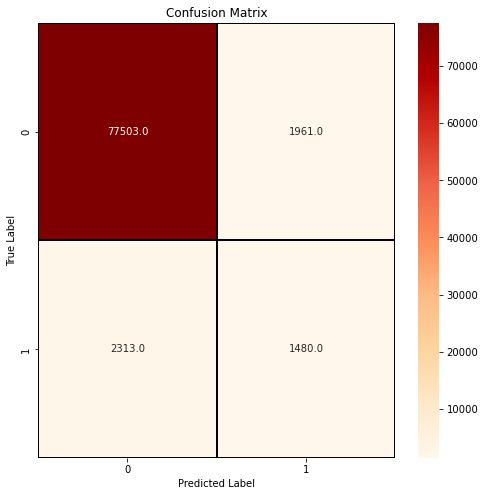

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()